In [42]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
from PIL import Image
from tqdm import tqdm
from scipy.signal import correlate2d
import cv2
from scipy import ndimage, datasets
import time
from scipy.interpolate import griddata

np.set_printoptions(precision=2)

In [160]:
PATCH_SIZE = 9
HALF_SIZE = PATCH_SIZE // 2

PATCH_REGION = lambda i, j : (slice(i - HALF_SIZE, i + HALF_SIZE + 1), \
                              slice(j - HALF_SIZE, j + HALF_SIZE + 1))

SOBEL_X = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1],
])

SOBEL_Y = np.array([
    [1, 2, 1],
    [0, 0, 0],
    [-1, -2, -1],
])

def create_gaussian_kernel(n):
    # Create an (n x n) grid of (x, y) coordinates
    x, y = np.meshgrid(np.linspace(-int(n/2), int(n/2), n), np.linspace(-int(n/2), int(n/2), n))

    # Calculate the Gaussian function with sigma = 1
    g = np.exp(-(x**2 + y**2) / 2)

    # Normalize the kernel (make its sum equal to 1)
    g /= g.sum()

    return g

NORMALIZED_PATCH_GAUSSIAN = create_gaussian_kernel(PATCH_SIZE)

def hessian(img_pt):
    # First order derivative
    grad_x = correlate2d(img_pt, SOBEL_X, mode='valid')
    grad_y = correlate2d(img_pt, SOBEL_Y, mode='valid')

    # Second order derivative
    grad_xx = correlate2d(grad_x, SOBEL_X, mode='valid')[0, 0]
    grad_yy = correlate2d(grad_y, SOBEL_Y, mode='valid')[0, 0]
    grad_xy = correlate2d(grad_x, SOBEL_Y, mode='valid')[0, 0]

    # Hessian matrix
    hessian_matrix = np.array([[grad_xx, grad_xy], [grad_xy, grad_yy]])

    return hessian_matrix

def hessian_nD(img_pt):
    n_channels = img_pt.shape[-1]
    hess = np.zeros((2, 2))

    for c in range(n_channels):
        channel_hessian = hessian(img_pt[..., c])
        hess += channel_hessian
    
    hess *= 1 / n_channels

    return hess

def grad(img_pt):
    grad_x = np.sum(img_pt * SOBEL_X)
    grad_y = np.sum(img_pt * SOBEL_Y)

    gradient = np.array([grad_x, grad_y])
    norm = (np.linalg.norm(gradient))
    
    if norm > 0:
        unit_grad = gradient / norm
    else:
        unit_grad = gradient

    return unit_grad, norm

def grad_nD(img_pt):
    n_channels = img_pt.shape[-1]
    gradient = np.zeros(2)

    for c in range(n_channels):
        channel_unit_vec, channel_norm = grad(img_pt[..., c])
        gradient += channel_norm * channel_unit_vec
    
    gradient *= 1 / n_channels

    norm = np.linalg.norm(gradient)
    if norm > 0:
        unit_grad = gradient / norm
    else:
        unit_grad = gradient

    return unit_grad, norm

In [161]:
class MaskWithBoundary:
    def __init__(self, mask, dilation_radius = 1):
        assert mask.dtype == bool

        self.array = mask
        self.init_boundary_pixels()

        self.dilation_radius = dilation_radius    
        self.dilate_mask()
        
        def find_bounding_box():
            rows = np.any(~self.array, axis=1)
            cols = np.any(~self.array, axis=0)
            rmin, rmax = np.where(rows)[0][[0, -1]]
            cmin, cmax = np.where(cols)[0][[0, -1]]

            return rmin, rmax + 1, cmin, cmax + 1

        self.rmin, self.rmax, self.cmin, self.cmax = find_bounding_box()

    def __getitem__(self, idx):
        return self.array[idx]

    def dilate_mask(self):
        self.dilated_array = self.array.copy()

        def fill_square(i, j):
            start_i = max(0, i - self.dilation_radius)
            end_i = min(self.array.shape[0], i + self.dilation_radius + 1)
            start_j = max(0, j - self.dilation_radius)
            end_j = min(self.array.shape[1], j + self.dilation_radius + 1)

            self.dilated_array[start_i : end_i, start_j : end_j] = 0
        
        for (i, j) in self.boundary_pixels:
            fill_square(i, j)

    def init_boundary_pixels(self):
        height, width = self.array.shape
        self.boundary_pixels = set()

        for i in range(height):
            for j in range(width):
                if self.array[i, j]: continue

                if i == 0 or i == height - 1 or j == 0 or j == width - 1:
                    self.boundary_pixels.add((i, j))

                elif self.array[i - 1, j] or self.array[i + 1, j] or self.array[i, j - 1] or self.array[i, j + 1]:
                    self.boundary_pixels.add((i, j))
        
    def update_boundary_pixels(self, i, j):
        # iterate through edges of patch centered at i, j
        for k in range(-HALF_SIZE, HALF_SIZE + 1):
            if not self.array[i + k, j - HALF_SIZE - 1]:
                self.boundary_pixels.add((i + k, j - HALF_SIZE - 1))
            if not self.array[i + k, j + HALF_SIZE + 1]:
                self.boundary_pixels.add((i + k, j + HALF_SIZE + 1))
            if not self.array[i - HALF_SIZE - 1, j + k]:
                self.boundary_pixels.add((i - HALF_SIZE - 1, j + k))
            if not self.array[i + HALF_SIZE + 1, j + k]:
                self.boundary_pixels.add((i + HALF_SIZE + 1, j + k))

    def fill_patch(self, i, j):
        patch_region = PATCH_REGION(i, j)
        idxs = [(i + y, j + x) for x in range(-HALF_SIZE, HALF_SIZE + 1) for y in range(-HALF_SIZE, HALF_SIZE + 1)]
        self.boundary_pixels -= set(idxs)
        
        self.array[patch_region] = True
        self.update_boundary_pixels(i, j)
        self.dilate_mask()

    def empty(self):
        return len(self.boundary_pixels) == 0
    
    def render_boundary(self):
        mask_with_boundary = 255 * self.array.copy().astype(np.uint32)

        for (i, j) in self.boundary_pixels:
            mask_with_boundary[i, j] = 128

        plt.imshow(mask_with_boundary, cmap='grey')
        plt.show()

In [162]:
def overlay_mask_image(mask_with_boundary, image, pxs=[], show=True):
    mask_integer = mask_with_boundary.array.astype(np.uint8)
    mask_array = 255 * np.stack((mask_integer,) * 3, axis=-1)

    # Check if the image is grayscale (HxWx1) or RGB (HxWx3)
    if image.shape[-1] == 1:  # Grayscale
        rgb_image = np.stack((image.squeeze(),) * 3, axis=-1)  # Remove the last dimension and stack
    else:  # RGB
        rgb_image = np.copy(image)  # Make a copy of the image

    for (i, j) in pxs:
        rgb_image[i, j] = np.array([0, 0, 255])

    # Blend the image and the mask
    all_mask_pixels = [(i, j) for i in range(mask_array.shape[0]) for j in range(mask_array.shape[1]) if not mask_with_boundary[i, j]]
    interior_rows = [r for (r, _) in all_mask_pixels]
    interior_cols = [c for (_, c) in all_mask_pixels]
    rgb_image[interior_rows, interior_cols] = [255, 255, 255]

    boundary_pixels = list(mask_with_boundary.boundary_pixels)
    boundary_rows = [r for (r, _) in boundary_pixels]
    boundary_cols = [c for (_, c) in boundary_pixels]
    rgb_image[boundary_rows, boundary_cols] = [255, 0, 0]

    if show:
        plt.imshow(rgb_image.astype(np.uint32))
        plt.show()
    else:
        return rgb_image.astype(np.uint32)

In [168]:
class ExemplarImageInpaint:
    def __init__(self, patch_size, image, sigma=3):
        self.patch_size = patch_size
        self.patch_area = self.patch_size ** 2

        self.half_size = patch_size // 2
        self.image = image.astype(np.uint32).reshape((image.shape[0], image.shape[1], -1))
        self.height, self.width, self.channels = self.image.shape
        self.ys, self.xs = np.ogrid[0 : self.height, 0 : self.width]

        self.ALPHA = 255    # Normalizing constant, maximum pixel value
        self.SIGMA = sigma  # Constant for random neighbor search
        self.OMEGA = 0.7    # Constant for slowing down confidence deterioration
        # self.LAMBDA = 5     # Number of exemplar patches to blend together
        # self.DELTA = 0.1    # Blah

        if self.channels == 1:
            self.luminance_image = self.image[:, :, 0]
        else:
            # TODO: use better RGB to grayscale conversion
            self.luminance_image = np.sum(self.image, axis=-1) / 3

    def clamp_idx(self, ij):
        i, j = ij

        return [
            min(self.height - self.half_size - 1, max(self.half_size, i)),
            min(self.width - self.half_size - 1, max(self.half_size, j))
        ]

    def compute_priority(self, patch_coords, confidence_table, mask):
        i, j = patch_coords
        patch_region = PATCH_REGION(i, j)

        image_3filter = self.image[i-1:i+2, j-1:j+2]
        image_5filter = self.image[i-2:i+2+1, j-2:j+2+1]
        mask_3filter = mask[i-1:i+2, j-1:j+2]

        confidence = np.sum(mask[patch_region] * confidence_table[patch_region], dtype=float)
        confidence /= self.patch_area

        rectified_confidence = (1 - self.OMEGA) * confidence + self.OMEGA

        (img_grad_x, img_grad_y), img_grad_norm = grad_nD(image_3filter)
        img_grad = img_grad_norm * np.array([img_grad_x, img_grad_y])

        img_hessian = hessian_nD(image_5filter)

        boundary_normal, _boundary_grad_norm = grad(mask_3filter)
        
        curvature = np.dot(img_grad, img_hessian @ img_grad) / img_grad_norm ** 3

        isophote = img_grad_norm * np.array([-img_grad_y, img_grad_x])

        data = abs(np.dot(isophote, boundary_normal) / (curvature + 1.0))
        # data = abs(np.dot(isophote, boundary_normal))
        data /= self.ALPHA

        return confidence, rectified_confidence, data
    
    def compute_distance(self, patch_coords, exemp_coords, mask):
        ip, jp = patch_coords
        ie, je = exemp_coords

        patch_region = PATCH_REGION(ip, jp)
        exemp_region = PATCH_REGION(ie, je)

        patch_mask = mask[patch_region][:, :, np.newaxis]

        patch_mask_sum = np.sum(patch_mask, dtype=float)
        patch_mask_not_sum = np.sum(~patch_mask, dtype=float)

        # compute MSD
        M_p = patch_mask * self.image[patch_region]
        M_e = patch_mask * self.image[exemp_region]

        msd = np.sum((M_p - M_e) ** 2, dtype=float)
        msd /= patch_mask_sum

        # compute SMD
        smd1 = np.sum(patch_mask * self.image[patch_region], dtype=float)
        smd2 = np.sum(~patch_mask * self.image[exemp_region], dtype=float)

        smd1 /= patch_mask_sum
        smd2 /= patch_mask_not_sum

        smd = (smd1 - smd2) ** 2

        return msd + smd

    # def compute_distance(self, patch_coords, exemp_coords, mask):
    #     ip, jp = patch_coords
    #     ie, je = exemp_coords

    #     patch_region = PATCH_REGION(ip, jp)
    #     exemp_region = PATCH_REGION(ie, je)

    #     patch_mask = mask[patch_region][:, :, np.newaxis]

    #     patch_mask_sum = np.sum(patch_mask, dtype=float)
    #     patch_mask_not_sum = np.sum(~patch_mask, dtype=float)


    #     # Compute the sum of the squared differences of mean R, G, and B values
    #     # between the masked patch and masked exemplar patch in the image
    #     channel_diffs = np.empty(shape=(self.channels,), dtype=np.int64)
    #     masked_image_patch = patch_mask * self.image[patch_region]
    #     masked_image_exemp = patch_mask * self.image[exemp_region]

    #     for c in self.channels:
    #         mean_patch_cval = np.sum(masked_image_patch[..., c]) / patch_mask_sum
    #         mean_exemp_cval = np.sum(masked_image_exemp[..., c]) / patch_mask_sum
    #         channel_diffs[c] = (mean_patch_cval - mean_exemp_cval) ** 2

    #     ssd_mean = np.sum(channel_diffs)
        
    #     masked_luminescence_patch = patch_mask * self.luminance_image[patch_region]
    #     masked_luminescence_exemp = patch_mask * self.luminance_image[exemp_region]
        
    #     ncc = np.sum(masked_luminescence_patch * masked_luminescence_exemp) ** 2
    #     ncc /= np.sum(masked_luminescence_patch)

    #     # compute MSD
    #     M_p = patch_mask * self.image[patch_region]
    #     M_e = patch_mask * self.image[exemp_region]

    #     msd = np.sum((M_p - M_e) ** 2, dtype=float)
    #     msd /= patch_mask_sum

    #     # compute SMD
    #     smd1 = np.sum(patch_mask * self.image[patch_region], dtype=float)
    #     smd2 = np.sum(~patch_mask * self.image[exemp_region], dtype=float)

    #     smd1 /= patch_mask_sum
    #     smd2 /= patch_mask_not_sum

    #     smd = (smd1 - smd2) ** 2

    #     return msd + smd

    def rejection_sample_patches(self, i, j, mask, target_n_sampled_patches):
        # distances = np.abs((self.xs - j) + (self.ys - i))
        # distances = np.exp(-distances / self.SIGMA)
        # distances *= mask.dilated_array
        # s = 2.0

        max_dim = max(self.image.shape)
        covariance = (max_dim / self.SIGMA)
        stddev = np.sqrt(covariance)
        
        _remaining = np.ones(target_n_sampled_patches, dtype=bool)
        candidate_is, candidate_js = np.empty(target_n_sampled_patches, dtype=int), np.empty(target_n_sampled_patches, dtype=int)
        
        while _remaining.any():
            n_remaining = np.sum(_remaining)

            candidate_is[_remaining] = np.minimum(self.height - self.half_size - 1,
                                                  np.maximum(self.half_size, np.random.normal(loc= i, scale=stddev, size=n_remaining)))
            candidate_js[_remaining] = np.minimum(self.width - self.half_size - 1,
                                                  np.maximum(self.half_size, np.random.normal(loc= j, scale=stddev, size=n_remaining)))

            for k in range(target_n_sampled_patches):
                if not _remaining[k]: continue

                _remaining[k] = not np.all( mask[PATCH_REGION(candidate_is[k], candidate_js[k])] )

        return candidate_is, candidate_js

    def fill_region(self, mask, n_exemplar_samples=50):
        assert mask.array.shape[0] == self.image.shape[0] and mask.array.shape[1] == self.image.shape[1]
        max_dim = max(self.image.shape)
            
        timing_specs = {
            'priorities': [0, 0],
            'exemplar': [0, 0],
            'fill': [0, 0],
        }

        # initialize confidence table to 0 for masked pixels, 1 for unmasked pixels
        confidence_table = mask.array.copy().astype(np.float32)
        n_iters = 0

        tot_n_tries = 0

        while not mask.empty():
            n_iters += 1

            start_time = time.time()

            priorities = {(i, j) : self.compute_priority((i, j), confidence_table, mask) for (i, j) in mask.boundary_pixels}
            ip, jp = max(priorities, key=lambda x: priorities[x][1] *  priorities[x][2])

            end_time = time.time()
            timing_specs['priorities'][1] = max(timing_specs['priorities'][1], end_time - start_time)
            timing_specs['priorities'][0] += end_time - start_time

            start_time = time.time()
            
            patch_region = PATCH_REGION(ip, jp)
            mask_region = mask[patch_region][:, :, np.newaxis] 

            max_confidence, _, _ = priorities[(ip, jp)]

            candidate_is, candidate_js = self.rejection_sample_patches(ip, jp, mask, n_exemplar_samples)

            exemplar_distances = []
            exemplar_locations = []

            for (ic, jc) in zip(candidate_is, candidate_js):
                c_exemplar_distance = self.compute_distance((ip, jp), (ic, jc), mask)

                if len(exemplar_distances) < self.LAMBDA or c_exemplar_distance < max(exemplar_distances):
                    if len(exemplar_distances) == self.LAMBDA:
                        max_index = exemplar_distances.index(max(exemplar_distances))
                        exemplar_distances.pop(max_index)
                        exemplar_locations.pop(max_index)

                    exemplar_distances.append(c_exemplar_distance)
                    exemplar_locations.append((ic, jc))

            exemplar_weights = [ np.exp(-d / (self.ALPHA * 2 * self.DELTA)) for d in exemplar_distances ]
            total_weight = np.sum(exemplar_weights)

            normalized_exemplar_weights = [ w / total_weight for w in exemplar_weights ]

            fused_exemplar_patch = normalized_exemplar_weights[0] * self.image[PATCH_REGION(*exemplar_locations[0])]
            for k in range(1, self.LAMBDA):
                fused_exemplar_patch += normalized_exemplar_weights[k] * self.image[PATCH_REGION(*exemplar_locations[k])]

            fused_exemplar_patch = np.clip(fused_exemplar_patch, a_min=0, a_max=255).astype(self.image.dtype)
            # n_candidates = 0

            # while n_candidates < n_exemplar_samples:
            #     s = 2
            #     offset = np.random.multivariate_normal([0, 0], [[max_dim / s, 0], [0, max_dim / s]])
            #     i, j = ip + int(offset[0]), jp + int(offset[1])
                
            #     ic, jc = self.clamp_idx((i, j))
            #     exemplar_region_c = PATCH_REGION(ic, jc)

            #     if np.sum(mask[exemplar_region_c]) == self.patch_area:
            #         n_candidates += 1
            #         c_exemplar_distance = self.compute_distance((ip, jp), (ic, jc), mask)
                    
            #         # gaussian_pts.append( (ic, jc) )

            #         if c_exemplar_distance < exemplar_distance:
            #             exemplar_distance = c_exemplar_distance
            #             exemplar_i, exemplar_j = ic, jc


            end_time = time.time()
            timing_specs['exemplar'][1] = max(timing_specs['exemplar'][1], end_time - start_time)
            timing_specs['exemplar'][0] += end_time - start_time

            start_time = time.time()

            self.image[patch_region] *=  mask_region
            self.image[patch_region] += ~mask_region * fused_exemplar_patch

            # if self.channels == 3:
            #     self.image[patch_region] *=  mask_region
            #     self.image[patch_region] += ~mask_region * self.image[PATCH_REGION(exemplar_i, exemplar_j)]

            #     self.luminance_image[patch_region] *=  mask_region
            #     self.luminance_image[patch_region] += ~mask_region * self.luminance_image[PATCH_REGION(exemplar_i, exemplar_j)]
            # else:
            #     self.image[patch_region] *=  mask_region
            #     self.image[patch_region] += ~mask_region * self.image[PATCH_REGION(exemplar_i, exemplar_j)]

            confidence_table[patch_region] *= mask[patch_region]
            confidence_table[patch_region] += ~mask[patch_region] * max_confidence

            mask.fill_patch(ip, jp)

            end_time = time.time()
            timing_specs['fill'][1] = max(timing_specs['fill'][1], end_time - start_time)
            timing_specs['fill'][0] += end_time - start_time

        plt.imshow(self.image, cmap='gray')
        plt.title("Inpainted Image")
        plt.show()

        plt.imshow(confidence_table, cmap='gray')
        plt.title("Confidence Table")
        plt.show()

        print(tot_n_tries/n_iters)
        print(f"Timing stats over {n_iters} iterations:")

        for x in timing_specs:
            print(f"{x}: {timing_specs[x][0] / n_iters * 1e3} ms avg, {timing_specs[x][1] * 1e3} ms max")

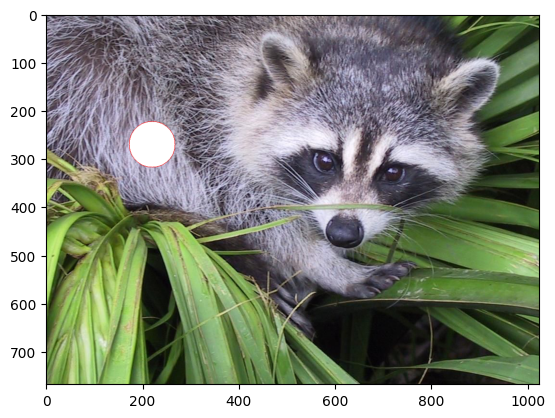

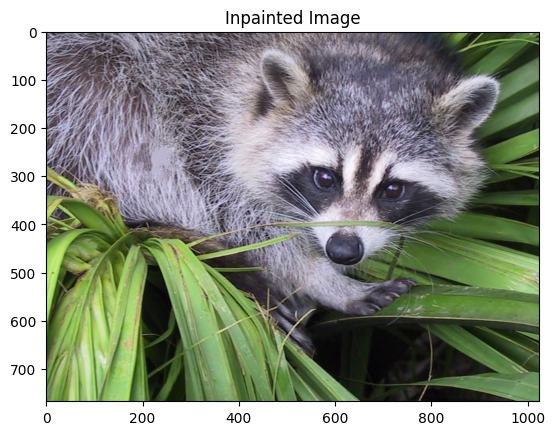

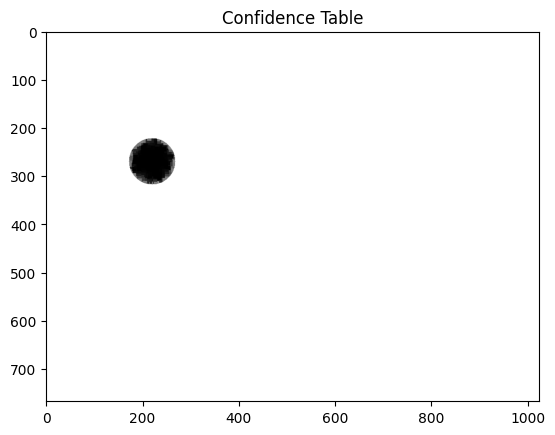

0.0
Timing stats over 210 iterations:
priorities: 30.17833800542922 ms avg, 47.40309715270996 ms max
exemplar: 2.182316780090332 ms avg, 4.750967025756836 ms max
fill: 0.43861298334030874 ms avg, 0.9226799011230469 ms max


In [169]:
# image = np.zeros((256, 256, 3))
# image[128:, :] = [128, 128, 128]
image = datasets.face().astype('int32')


y, x = np.ogrid[0:image.shape[0], 0:image.shape[1]]
_mask = np.ones((image.shape[0], image.shape[1]), dtype=bool)
_circle_condition = (x - 220) ** 2 + (y - 270) ** 2 <= 48 ** 2
_mask[_circle_condition] = False
mask = MaskWithBoundary(_mask)

overlay_mask_image(mask, image)

painter = ExemplarImageInpaint(PATCH_SIZE, image, 3.0)
painter.fill_region(mask, n_exemplar_samples=75)


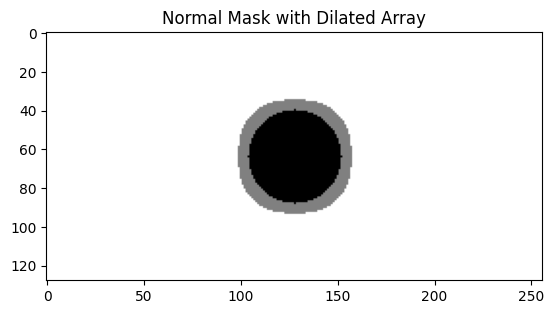

Par 2445 Tries
Par: 34.80887413024902ms
Seq 24456 Tries
Seq: 163.7430191040039ms


In [ ]:
h, w = 128, 256
sample_mask = np.ones((h, w), dtype=bool)
ys, xs = np.ogrid[0:h, 0:w]

cond = (xs - 128) ** 2 + (ys - 64) ** 2 <= 24 ** 2
sample_mask[cond] = 0

mask_with_boundary = MaskWithBoundary(sample_mask, dilation_radius=5)

plt.title("Normal Mask with Dilated Array")
plt.imshow(mask_with_boundary.array.astype(np.float32), cmap='gray')
plt.imshow(mask_with_boundary.dilated_array.astype(np.float32), cmap='gray', alpha=0.5)
plt.show()

def rejection_sample_patches(i, j, mask, target_n_sampled_patches):
    distances = np.sqrt((xs - j) ** 2 + (ys - i) ** 2)
    distances = np.exp(-distances / 3)
    distances *= mask.dilated_array

    maximum_distance = np.max(distances)

    _condition = np.ones(target_n_sampled_patches, dtype=bool)
    uniform_samples, candidate_is, candidate_js = [np.empty(target_n_sampled_patches) for _ in range(3)]

    while _condition.any():
        cnt+=1
        to_be_filled = np.sum(_condition)
        # Fill uniform_samples and candidate_is/candidate_js with new values wherever _condition is true

        uniform_samples[_condition] = np.random.uniform(0, 1, size=to_be_filled)
        candidate_is[_condition] = np.random.randint(0, h, size=to_be_filled)
        candidate_js[_condition] = np.random.randint(0, w, size=to_be_filled)

        candidate_distances = distances[candidate_is, candidate_js] / maximum_distance
        
        _condition = uniform_samples > candidate_distances
    print(f"Par {cnt} Tries")
    return candidate_is, candidate_js

start = time.time()
rejection_sample_patches(40, 128, mask_with_boundary, 50)
dur = time.time() - start
print(f"Par: {dur * 1e3}ms")

start = time.time()
rejection_sample_patches_seq(40, 128, mask_with_boundary, 50)
dur = time.time() - start
print(f"Seq: {dur * 1e3}ms")
# plt.imshow(sample_mask)
# plt.scatter(coordinates_js, coordinates_is, color="red")
# plt.title("Rejection Sampled Points")
# plt.show()